# Initialization

## Packages

In [1]:
import datetime, os
import numpy as np
import pandas as pd
import io
import matplotlib
import matplotlib.pyplot as plt
import random
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns

import tensorflow as tf
from keras.models import Model
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

np.random.seed(7)

In [2]:
from google.colab import drive
MOUNTPOINT = '/content/gdrive'
DATA_DIR = os.path.join(MOUNTPOINT, 'MyDrive/Membership_Inference/Data')
MODEL_DIR = os.path.join(MOUNTPOINT, 'MyDrive/Membership_Inference/Models')
SAVED_MODEL = os.path.join(MOUNTPOINT, 'MyDrive/Membership_Inference/Models_trained')
TRAIN_ATTACK = os.path.join(MOUNTPOINT, 'MyDrive/Membership_Inference/TrainAttack')
TEST_ATTACK = os.path.join(MOUNTPOINT, 'MyDrive/Membership_Inference/TestAttack')
drive.mount(MOUNTPOINT)

Mounted at /content/gdrive


In [3]:
%load_ext tensorboard
log_dir=os.path.join(MODEL_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Pipeline

In [4]:
def perf_measure(y_actual, y_pred):
  TP = 0
  FP = 0
  TN = 0
  FN = 0

  for i in range(len(y_pred)): 
    if y_actual[i]==y_pred[i]==1:
      TP += 1
    if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
      FP += 1
    if y_actual[i]==y_pred[i]==0:
      TN += 1
    if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
      FN += 1
  return(TP, FP, TN, FN)

# Data

In [5]:
TARGET_DIR = 'IN_TargetModel.csv'
DISTRACTION_DIR = 'OUT_TargetModel.csv'

IN_SHADOW1 = 'IN_ShadowModel1.csv'
OUT_SHADOW1 = 'OUT_ShadowModel1.csv'

IN_SHADOW2 = 'IN_ShadowModel2.csv'
OUT_SHADOW2 = 'OUT_ShadowModel2.csv'

## Train

In [6]:
in1_train_path = os.path.join(TRAIN_ATTACK, IN_SHADOW1)
in1_train_data = pd.read_csv(in1_train_path, delimiter=",")

out1_train_path = os.path.join(TRAIN_ATTACK, OUT_SHADOW1)
out1_train_data = pd.read_csv(out1_train_path, delimiter=",")

in2_train_path = os.path.join(TRAIN_ATTACK, IN_SHADOW2)
in2_train_data = pd.read_csv(in1_train_path, delimiter=",")

out2_train_path = os.path.join(TRAIN_ATTACK, OUT_SHADOW2)
out2_train_data = pd.read_csv(out1_train_path, delimiter=",")

In [7]:
print(in1_train_data.shape)
print(in2_train_data.shape)
print(out1_train_data.shape)
print(out2_train_data.shape)

(38691, 12)
(38691, 12)
(38642, 12)
(38642, 12)


In [8]:
frames = [in1_train_data, out1_train_data, in2_train_data, out2_train_data]
train_data = pd.concat(frames)

In [9]:
shuffled_train_data = tf.random.shuffle(train_data)

In [10]:
shuffled_train_data

<tf.Tensor: shape=(154666, 12), dtype=float64, numpy=
array([[6.1930600e-01, 1.8523476e-03, 3.7826612e-04, ..., 1.1762291e-05,
        0.0000000e+00, 0.0000000e+00],
       [2.3172522e-06, 9.9636520e-01, 1.8111228e-04, ..., 2.7677060e-03,
        1.0000000e+00, 0.0000000e+00],
       [1.8321595e-04, 9.7340626e-01, 1.5230829e-07, ..., 2.6549806e-04,
        1.0000000e+00, 0.0000000e+00],
       ...,
       [3.2299518e-08, 9.9682474e-01, 3.0630488e-11, ..., 9.8741700e-07,
        1.0000000e+00, 0.0000000e+00],
       [1.2220199e-06, 1.8546550e-03, 4.0500627e-13, ..., 7.1755520e-05,
        6.0000000e+00, 1.0000000e+00],
       [2.8821284e-02, 7.0780826e-01, 2.4772502e-04, ..., 1.1445528e-02,
        1.0000000e+00, 0.0000000e+00]])>

In [11]:
X_train = shuffled_train_data[:, 0:11]
y_train = shuffled_train_data[:, 11]

print(X_train.shape)
print(y_train.shape)

(154666, 11)
(154666,)


## Test

In [12]:
target_path = os.path.join(TEST_ATTACK, TARGET_DIR)
target_data = pd.read_csv(target_path, delimiter=",")

distraction_path = os.path.join(TEST_ATTACK, DISTRACTION_DIR)
distraction_data = pd.read_csv(distraction_path, delimiter=",")

In [13]:
print(target_data.shape)
print(distraction_data.shape)

(114302, 12)
(35816, 12)


In [14]:
half_target_data = target_data.head(35000)
half_distraction_data = distraction_data.head(35000)

In [15]:
frames = [half_target_data, half_distraction_data]
test_data = pd.concat(frames)

In [16]:
shuffled_test_data = tf.random.shuffle(test_data)

In [17]:
shuffled_test_data

<tf.Tensor: shape=(70000, 12), dtype=float64, numpy=
array([[3.5962430e-06, 9.9995875e-01, 2.4515416e-09, ..., 9.8409110e-06,
        1.0000000e+00, 1.0000000e+00],
       [1.1931083e-01, 8.8066030e-01, 6.7530264e-13, ..., 2.7723385e-07,
        1.0000000e+00, 1.0000000e+00],
       [1.2474499e-07, 9.9999640e-01, 6.7563910e-14, ..., 1.8890563e-07,
        1.0000000e+00, 0.0000000e+00],
       ...,
       [2.5113946e-05, 9.9775330e-01, 9.7953080e-08, ..., 2.1463393e-03,
        1.0000000e+00, 0.0000000e+00],
       [1.0649051e-02, 3.3077340e-02, 1.8783276e-04, ..., 5.4573565e-04,
        1.0000000e+00, 0.0000000e+00],
       [9.9202900e-01, 2.6659044e-03, 1.8431727e-08, ..., 5.1322980e-04,
        0.0000000e+00, 0.0000000e+00]])>

In [18]:
X_test = shuffled_test_data[:, 0:11]
y_test = shuffled_test_data[:, 11]

print(X_test.shape)
print(y_test.shape)

(70000, 11)
(70000,)


# Binary Classification


## Architecture

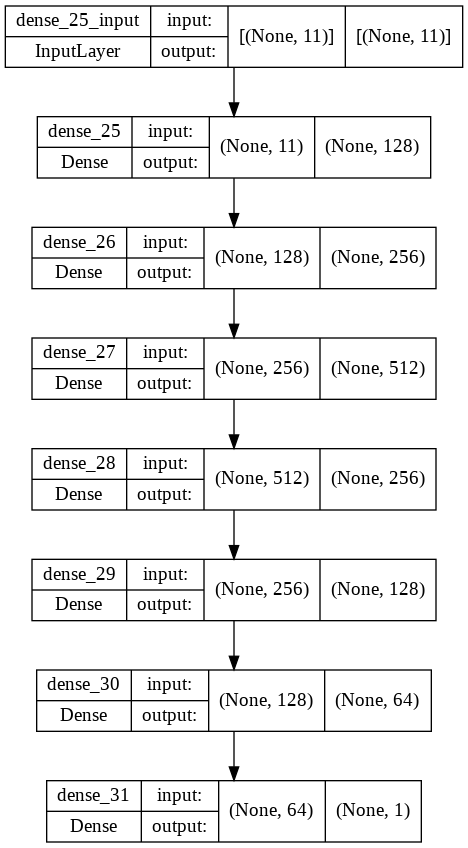

In [27]:
model = Sequential()
model.add(Dense(128, input_dim=(X_train.shape[1]), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

plot_model(model, show_shapes=True, to_file='AttackModel.png')

In [28]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 128)               1536      
                                                                 
 dense_26 (Dense)            (None, 256)               33024     
                                                                 
 dense_27 (Dense)            (None, 512)               131584    
                                                                 
 dense_28 (Dense)            (None, 256)               131328    
                                                                 
 dense_29 (Dense)            (None, 128)               32896     
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dense_31 (Dense)            (None, 1)                

## Training

In [29]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100)

Epoch 1/100
4834/4834 [==============================] - 22s 4ms/step - loss: 0.6803 - accuracy: 0.5394
Epoch 2/100
4834/4834 [==============================] - 21s 4ms/step - loss: 0.6709 - accuracy: 0.5575
Epoch 3/100
4834/4834 [==============================] - 21s 4ms/step - loss: 0.6659 - accuracy: 0.5640
Epoch 4/100
4834/4834 [==============================] - 21s 4ms/step - loss: 0.6623 - accuracy: 0.5656
Epoch 5/100
4834/4834 [==============================] - 21s 4ms/step - loss: 0.6602 - accuracy: 0.5686
Epoch 6/100
4834/4834 [==============================] - 21s 4ms/step - loss: 0.6581 - accuracy: 0.5718
Epoch 7/100
4834/4834 [==============================] - 21s 4ms/step - loss: 0.6565 - accuracy: 0.5730
Epoch 8/100
4834/4834 [==============================] - 21s 4ms/step - loss: 0.6546 - accuracy: 0.5759
Epoch 9/100
4834/4834 [==============================] - 21s 4ms/step - loss: 0.6528 - accuracy: 0.5778
Epoch 10/100
4834/4834 [==============================] - 21s 4m

In [ ]:
#model = tf.keras.models.load_model(os.path.join(SAVED_MODEL,"AttackModel.h5"))

In [30]:
model.save(os.path.join(SAVED_MODEL, "AttackModel.h5"))

In [ ]:
!tensorboard dev upload --logdir $log_dir. \
  --name "AttackModel" \
  --description "" \
  --one_shot

## Evaluation

In [31]:
train_loss, train_acc = model.evaluate(X_train, y_train)
print('\nTrain accuracy:', train_acc)

4834/4834 [==============================] - 14s 3ms/step - loss: 0.6186 - accuracy: 0.6309

Train accuracy: 0.6308820247650146


In [32]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', test_acc)

2188/2188 [==============================] - 6s 3ms/step - loss: 16.2454 - accuracy: 0.5949

Test accuracy: 0.5948857069015503


In [33]:
y_test_pred = model.predict(X_test) > 0.5
print(y_test_pred)

[[ True]
 [ True]
 [ True]
 ...
 [ True]
 [False]
 [ True]]


In [34]:
y_test_boolean = y_test > 0.5
print(y_test_boolean)

tf.Tensor([ True  True False ... False False False], shape=(70000,), dtype=bool)


In [36]:
print(y_test_pred[300])
print(y_test_boolean[300])

[ True]
tf.Tensor(True, shape=(), dtype=bool)


# Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

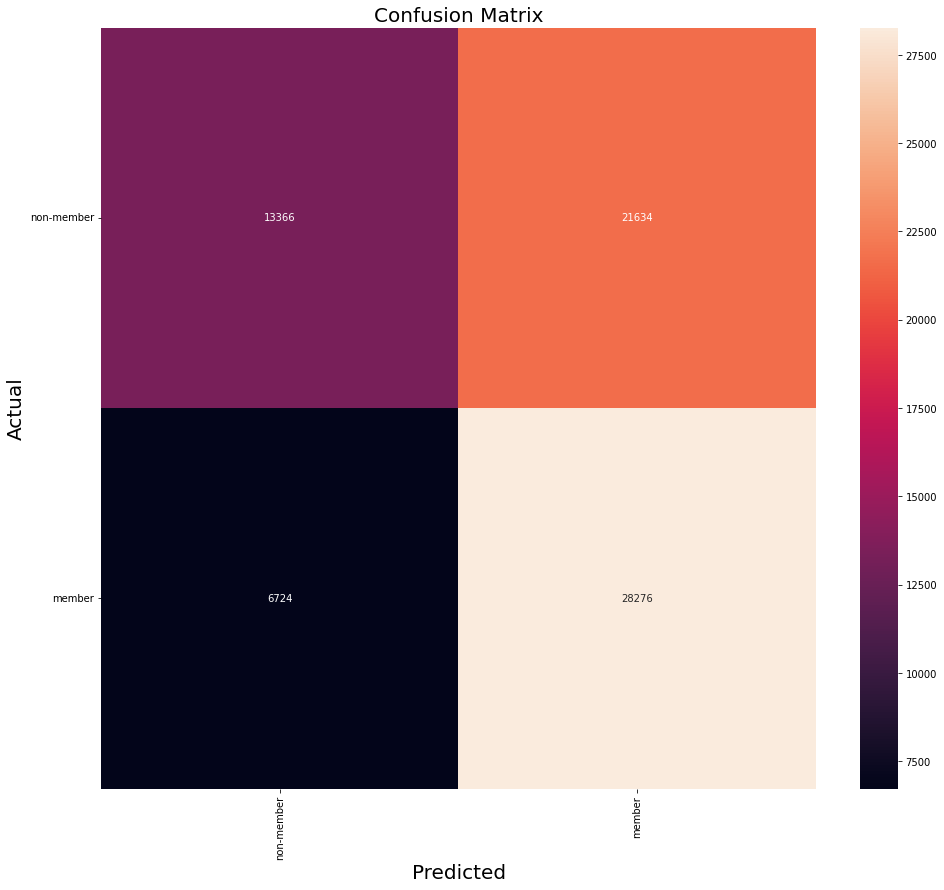

In [37]:
cf_matrix = confusion_matrix(y_test_boolean, y_test_pred)

labels = ['False', 'True']
class_names = ['non-member', 'member']

fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax, fmt = 'g');

ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('Actual', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=20)

In [38]:
print("Accuracy", accuracy_score(y_test_boolean, y_test_pred))
print("Precision", precision_score(y_test_boolean, y_test_pred))
print("Recall", recall_score(y_test_boolean, y_test_pred))

Accuracy 0.5948857142857142
Precision 0.5665397715888599
Recall 0.8078857142857143
